In [17]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_line_mesh, build_complex_from_mesh
from dctkit.math.opt import optctrl as oc
from deap import gp
from flex.gp import regressor as gps
from dctkit import config
import dctkit
import numpy as np
import ray
import math
from typing import Tuple, Callable, List
import os
from flex.gp.util import load_config_data
from flex.gp.primitives import add_primitives_to_pset_from_dict

import matplotlib.pyplot as plt

In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
os.environ["JAX_PLATFORMS"] = "cpu"
config()

In [3]:
def compile_individuals(toolbox, individuals_str_batch):
    return [toolbox.compile(expr=ind) for ind in individuals_str_batch]


def get_features_batch(individ_feature_extractors, individuals_str_batch):
    features_batch = [
        [fe(i) for i in individuals_str_batch] for fe in individ_feature_extractors
    ]

    indlen = features_batch[0]
    return indlen

In [4]:
def eval_MSE_sol(
    residual: Callable, X, y, S: SimplicialComplex, u_0: C.CochainP0
) -> float:

    num_nodes = S.num_nodes

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    os.environ["JAX_PLATFORMS"] = "cpu"
    config()

    # objective: squared norm of the residual of the equation + penalty on Dirichlet
    # boundary condition on the first node
    def obj(x, y):
        penalty = 100.0 * x[0] ** 2
        u = C.CochainP0(S, x)
        f = C.CochainP0(S, y)
        r = residual(u, f)
        total_energy = C.inner(r, r) + penalty
        return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    MSE = 0.0

    # set additional arguments of the objective function
    # (apart from the vector of unknowns)
    args = {"y": X}
    prb.set_obj_args(args)

    # minimize the objective
    u = prb.solve(x0=u_0.coeffs.flatten(), ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

    if y is not None:
        if (
            prb.last_opt_result == 1
            or prb.last_opt_result == 3
            or prb.last_opt_result == 4
        ):
            MSE = np.mean(np.linalg.norm(u - y) ** 2)
        else:
            MSE = math.nan

        if math.isnan(MSE):
            MSE = 1e5

    return MSE, [u]

In [5]:
def predict(
    individuals_str: list[str],
    toolbox,
    X,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    penalty: dict,
) -> List:

    callables = compile_individuals(toolbox, individuals_str)

    u = [None] * len(individuals_str)

    for i, ind in enumerate(callables):
        _, u[i] = eval_MSE_sol(ind, X, None, S, u_0)

    return u


def score(
    individuals_str: list[str],
    toolbox,
    X,
    y,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    penalty: dict,
) -> List:

    callables = compile_individuals(toolbox, individuals_str)

    MSE = [None] * len(individuals_str)

    for i, ind in enumerate(callables):
        MSE[i], _ = eval_MSE_sol(ind, X, y, S, u_0)

    return MSE


def fitness(
    individuals_str: list[str],
    toolbox,
    X,
    y,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    penalty: dict,
) -> Tuple[float,]:

    callables = compile_individuals(toolbox, individuals_str)
    indlen = get_features_batch([len], individuals_str)

    fitnesses = [None] * len(individuals_str)
    for i, ind in enumerate(callables):
        MSE, _ = eval_MSE_sol(ind, X, y, S, u_0)

        # add penalty on length of the tree to promote simpler solutions
        fitnesses[i] = (MSE + penalty["reg_param"] * indlen[i],)

    return fitnesses

In [ ]:
filename = "sr_dec.yaml"

regressor_params, config_file_data = load_config_data(filename)

# generate mesh and dataset
mesh, _ = generate_line_mesh(num_nodes=11, L=1.0)
S = build_complex_from_mesh(mesh)
S.get_hodge_star()
x = S.node_coords
num_nodes = S.num_nodes

# generate training and test datasets
# exact solution = x²
u = C.CochainP0(S, np.array(x[:, 0] ** 2, dtype=dctkit.float_dtype))
# compute source term such that u solves the discrete Poisson equation
# Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
f = C.laplacian(u)
f.coeffs *= -1.0

X_train = np.array(f.coeffs.ravel(), dtype=dctkit.float_dtype)
y_train = np.array(u.coeffs.ravel(), dtype=dctkit.float_dtype)

# initial guess for the unknown of the Poisson problem (cochain of nodals values)
u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
u_0 = C.CochainP0(S, u_0_vec)

# define primitive set for the residual of the discrete Poisson equation
pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)

# rename arguments of the residual
pset.renameArguments(ARG0="u")
pset.renameArguments(ARG1="f")

pset = add_primitives_to_pset_from_dict(pset, config_file_data["gp"]["primitives"])


penalty = config_file_data["gp"]["penalty"]
common_params = {"S": S, "u_0": u_0, "penalty": penalty}

gpsr = gps.GPSymbolicRegressor(
    pset_config=pset,
    fitness=fitness,
    score_func=score,
    predict_func=predict,
    print_log=True,
    common_data=common_params,
    seed_str=None,
    save_best_individual=True,
    save_train_fit_history=True,
    output_path="./",
    remove_init_duplicates=True,
    **regressor_params
)

gpsr.fit(X_train, y_train, X_val=X_train, y_val=y_train)

u_best = gpsr.predict(X_train)

fit_score = gpsr.score(X_train, y_train)

gpsr.save_best_test_sols(X_train, "./")

ray.shutdown()

2026-01-14 16:24:06,315	INFO worker.py:2007 -- Started a local Ray instance.


Generating initial population(s)...
 Removing duplicates from initial population(s)...
 DONE.
DONE.
Evaluating initial population(s)...
DONE.
 -= START OF EVOLUTION =- 
   	     	           fitness            	             size             
   	     	------------------------------	------------------------------
gen	evals	min   	avg  	max   	std   	min	avg 	max	std   
1  	20   	0.7327	2.962	3.4333	0.6372	3  	6.45	11 	2.6547
Best individuals of this generation:
AddCP0(AddCP0(u, f), delP1(cobP0(u)))
2  	20   	0.7327	2.537	3.1333	0.8022	3  	4.7 	11 	2.1   
Best individuals of this generation:
AddCP0(AddCP0(u, f), delP1(cobP0(u)))
3  	20   	0.7327	2.487	3.0333	0.7736	3  	4.2 	11 	2.1354
Best individuals of this generation:
AddCP0(AddCP0(u, f), delP1(cobP0(u)))
4  	20   	0.7327	2.2107	2.8333	0.8276	3  	5.8 	15 	3.8678
Best individuals of this generation:
AddCP0(AddCP0(u, f), delP1(cobP0(u)))
5  	20   	0.7327	1.9235	2.8333	0.8041	3  	7.85	15 	4.0899
Best individuals of this generation:
AddCP0

(pid=gcs_server) [2026-01-14 16:24:35,565 E 5918 5918] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2026-01-14 16:24:36,311 E 6039 6039] (raylet) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


8  	20   	0.5   	0.8013	1.1   	0.1539	5  	7.8 	11 	1.4697
Best individuals of this generation:
AddCP0(f, delP1(cobP0(u)))


(fitness pid=6112) [2026-01-14 16:24:37,817 E 6112 6393] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2026-01-14 16:24:38,093 E 30791 6102] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


9  	20   	0.5   	0.6947	0.9327	0.1357	5  	6.8 	9  	1.249 
Best individuals of this generation:
AddCP0(f, delP1(cobP0(u)))
10 	20   	0.5   	0.6382	0.7327	0.1022	5  	6.3 	7  	0.9539
Best individuals of this generation:
AddCP0(f, delP1(cobP0(u)))
 -= END OF EVOLUTION =- 
The best individual is AddCP0(f, delP1(cobP0(u)))
The best fitness on the training set is 0.5
String of the best individual saved to disk.
Training fitness history saved to disk.
Best individual solution evaluated over the test set saved to disk.


(fitness pid=6116) [2026-01-14 16:24:38,027 E 6116 6787] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 15x across cluster]


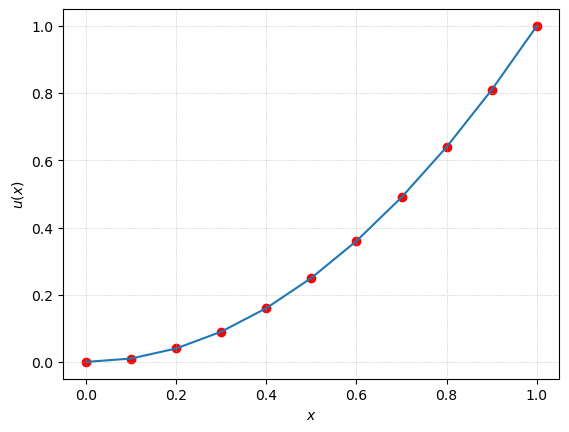

In [32]:
plt.plot(x[:,0], y_train)
plt.scatter(x[:,0], u_best, c="r")
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.show()